In [1]:
import os
import shutil
import csv
import random, deepdish as dd
import fnmatch, numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import DistanceMetric

In [2]:
DATA_DIR = '/home/jvidyala/data/original_data/'
CLUSTER_DIR = '/home/jvidyala/data/cluster_test/'

Create genres and tracks to store genres & track-ids, respectively

In [4]:
genres,tracks = [],[]
with open('msd-genre-dataset.txt','rb') as f:
    reader = csv.reader(f)
    for idx,row in enumerate(reader):
        if idx>=10:
            genres.append(row[0])
            tracks.append(row[1])

Random sample of n=100 tracks' data

In [36]:
idxs = []
for track in random.sample(tracks,100):
    idxs.append(tracks.index(track))
    path = DATA_DIR+track[2]+'/'+track[3]+'/'+track[4]+'/'+track+'.h5'
    try:
        shutil.copy(path,CLUSTER_DIR)
    except IOError as e:
        print(e)
        
    

In [37]:
label_set = {tracks[i]:genres[i] for i in idxs}
os.chdir('/home/jvidyala/data/')
dd.io.save('label_set.h5',label_set)

Run from here

In [3]:
os.chdir(CLUSTER_DIR)

In [4]:
mfcc_coeffs = {filename: [] for idx,filename in enumerate(fnmatch.filter(os.listdir(CLUSTER_DIR),'*.h5'))}
avg_feature_vector = {filename: [] for idx,filename in enumerate(fnmatch.filter(os.listdir(CLUSTER_DIR),'*.h5'))}
for file in fnmatch.filter(os.listdir(CLUSTER_DIR),'*.h5'):
    try:
        temp_load = dd.io.load(file)['analysis']['segments_timbre']
        mfcc_coeffs[file] = temp_load
        temp = []
        for j in range(12):
            feature_set = [(mfcc_coeffs[file][j]) for i in range(mfcc_coeffs[file].shape[0])]
            avg_feature = np.mean(np.array(feature_set))
            temp.append(avg_feature)
        feature_vector[file]=temp
    except IOError as e:
        print(e)

Create 6-item vectors for each song consisting of statistical metrics

In [30]:
def stat_distribution_calc(mfcc_coeff):
    stat_coeffs = []
    for idx in range(12):
        stat_vector = []
        coeff_val = np.array([mfcc_coeff[i][idx] for i in range(len(mfcc_coeff))])
        stat_vector = [np.mean(coeff_val),np.std(coeff_val),max(coeff_val),min(coeff_val),np.percentile(coeff_val,25),np.percentile(coeff_val,75)]
        stat_coeffs.append(stat_vector)
    return stat_coeffs

In [34]:
stat_measures = {file:stat_distribution_calc(vector) for file,vector in mfcc_coeffs.items()}

Create training sets for GMMs

In [94]:
os.chdir('/home/jvidyala/data')
label_file = dd.io.load('label_set.h5')

avg_mfcc_vectors, stat_coeff_vectors,genre_label = [],[],[]
for avg_val,stat_val in zip(avg_feature_vector.items(),stat_measures.items()):  
    avg_mfcc_vectors.append(avg_val[1])
    for i in range(12):
        stat_coeff_vectors.append(stat_val[1][i])
    genre_label.append(label_file.get(avg_val[0][:-3]))

In [61]:
print(len(avg_mfcc_vectors),len(avg_mfcc_vectors[0]))
print(len(stat_coeff_vectors),len(stat_coeff_vectors[0]))

(100, 12)
(1200, 6)


PCA dimensionality reduction and plotting 

In [7]:
pca = PCA(n_components=2)
X_r = pca.fit(avg_mfcc_vectors).transform(avg_mfcc_vectors)
colors = ['b','g','r','y','c','m','k','pink','darkorange']
mapping = {'jazz and blues':'b',
           'classic pop and rock':'g',
          'classical':'r',
          'metal':'y', 
           'punk':'c',
           'pop':'m',
           'dance and electronica':'k',
           'soul and reggae':'pink',
           'folk':'darkorange'}
color_set = [mapping[val] for val in genre_label]

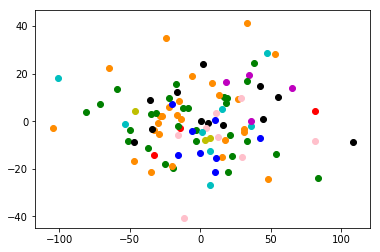

In [8]:
for i in range(len(X_r)):
    plt.scatter(X_r[i,0],X_r[i,1],color=color_set[i])
plt.show()

Function to calculate Mahalanobis distance for each point in associated Gaussian distribution

In [14]:
def mahalanobis(x,mean,cov):
    cov_inverse = np.linalg.inv(cov)
    return np.matmul(np.matmul(x-mean,cov_inverse),x-mean)

Checking whether n-component GMM trained on entire dataset better than 1-component GMM trained on genre-specific dataset

In [89]:
def distance_comparison(n_clusters,feature_vectors,genre_split=0):
    
    distance_metric = [0]*n_clusters
    if genre_split==0:
        cluster_population = [0]*n_clusters
        gmm = GaussianMixture(n_components=n_clusters,covariance_type='tied').fit(feature_vectors)
        predicted_labels = gmm.predict(feature_vectors)
        probs = gmm.predict_proba(feature_vectors)

        for idx, (label,prob) in enumerate(zip(predicted_labels,probs)):
            cluster_id = int(np.where(prob==max(prob))[0])
            cluster_population[cluster_id]+=1
            distance_metric[cluster_id]+=mahalanobis(np.array(feature_vectors[idx]),gmm.means_[cluster_id],gmm.covariances_)
    
        return distance_metric,gmm
    
    else:
        gmms = []
        for idx,genre in enumerate(set(genre_label)):
            train_set = [vector for vector in avg_mfcc_vectors if genre_label[avg_mfcc_vectors.index(vector)]==genre]
            gmm_genre = GaussianMixture(n_components=1,covariance_type='tied').fit(train_set)
            for vector in train_set:
                distance_metric[idx]+=mahalanobis(np.array(vector),gmm_genre.means_[0],gmm_genre.covariances_) 
            gmms.append(gmm_genre)
        return distance_metric,gmms
    

In [93]:
distances, gmm = distance_comparison(n_clusters=9,feature_vectors=avg_mfcc_vectors,genre_split=1)